In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.optim import SGD, Adam
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tqdm

In [228]:
X, y = make_classification(1000, 20, n_informative=10, random_state=0)

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [229]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        # self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [230]:
def train(model, optimizer_class, lr, negative_loss = False, create_plot = True, EPOCHS = 200):
    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr)

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train) * (-1 if negative_loss else 1)
        loss_list[epoch] = loss.item() * (-1 if negative_loss else 1)
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()

    with torch.no_grad():
        y_pred = model(X_test).numpy()
    # print("Pred Accuracy", accuracy_score(np.argmax(y_pred,axis=1), y_test))
    # print("Inverse Pred Accuracy", accuracy_score(1-np.argmax(y_pred,axis=1), y_test))

    if create_plot:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 6), sharex=True)

        ax1.plot(accuracy_list)
        ax1.set_ylabel("validation accuracy")
        ax2.plot(loss_list)
        ax2.set_ylabel("validation loss")
        ax2.set_xlabel("epochs")
    
    return accuracy_list, loss_list

In [231]:
# "{}".format(Adam) 
Adam.__name__

'Adam'

In [232]:
def exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [False],
    epochs  = [200],
    ):

    # Init model
    model = Model(X_train.shape[1])

    accs = []
    losses = []

    for _opt, _neg_loss, _n_epoch in zip(optimizers, negative_loss, epochs):
        _accs, _losses = train(model, _opt[0], _opt[1], negative_loss = _neg_loss, EPOCHS=_n_epoch, create_plot=False)
        accs.append(_accs)
        losses.append(_losses)
    
    # accs = np.concatenate(accs)
    # losses = np.concatenate(losses)
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(6*sum(epochs)/200, 6), sharex=True)

    axs_top = max(np.concatenate(losses))+0.02

    epoch_count = 1
    for _idx, _epoch in enumerate(epochs):
        epoch_count+=_epoch

        _x = [i for i in range(epoch_count-_epoch, epoch_count)]
        ax1.plot(_x, accs[_idx],  color='g' if negative_loss[_idx] else "r")
        ax2.plot(_x, losses[_idx], color='g' if negative_loss[_idx] else "r")
        
        ax1.axvline(epoch_count, ls="--", color="k")
        ax2.axvline(epoch_count, ls="--", color="k")

        ax2.text(epoch_count-_epoch/2, axs_top, 
        'Optimizer: {}, LR: {}, Reverse Loss: {}'.format(
            optimizers[_idx][0].__name__,
            optimizers[_idx][1],
            negative_loss[_idx],
            ),
        c="k",
        horizontalalignment='center',
        verticalalignment='bottom')
    
    ax2.set_xlabel("epochs")
    ax1.set_ylabel("validation accuracy")
    ax2.set_ylabel("validation loss")

# Learn

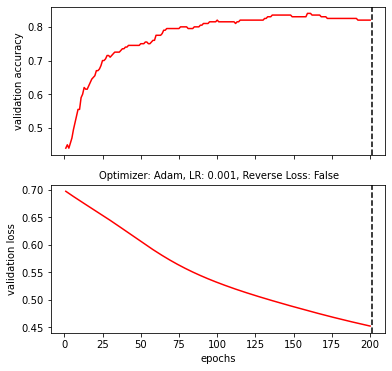

In [233]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [False],
    epochs  = [200],
    )

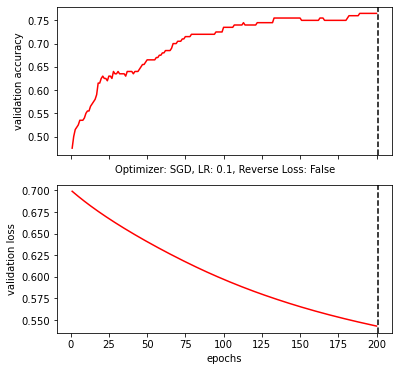

In [234]:
exam_unlearning(
    optimizers = [(SGD, 0.1)],
    negative_loss = [False],
    epochs  = [200],
    )

# Unlearn

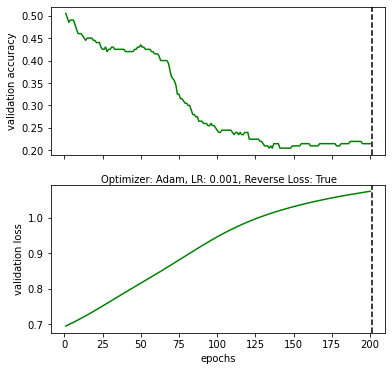

In [235]:
exam_unlearning(
    optimizers = [(Adam, 0.001)],
    negative_loss = [True],
    epochs  = [200],
    )

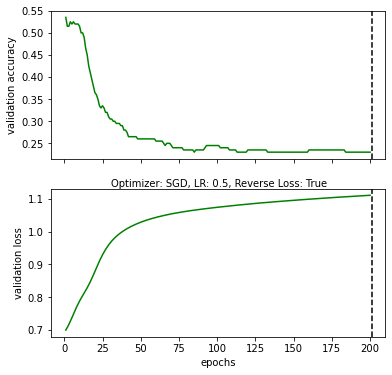

In [236]:
exam_unlearning(
    optimizers = [(SGD, 0.5)],
    negative_loss = [True],
    epochs  = [200],
    )

# Unlearn -> Learn

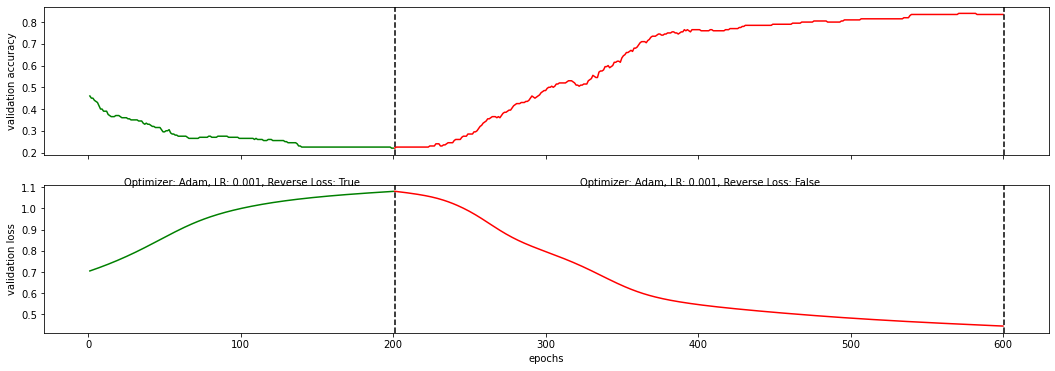

In [237]:
exam_unlearning(
    optimizers = [(Adam, 0.001), (Adam, 0.001)],
    negative_loss = [True, False],
    epochs  = [200, 400],
    )

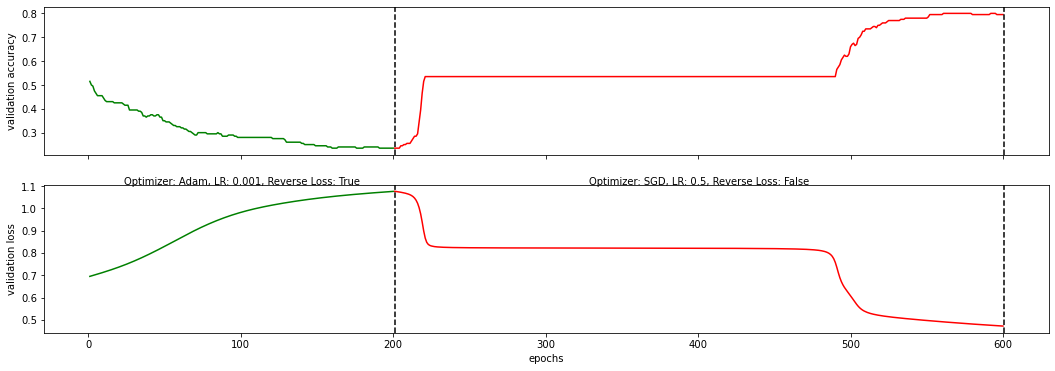

In [238]:
exam_unlearning(
    optimizers = [(Adam, 0.001), (SGD, 0.5)],
    negative_loss = [True, False],
    epochs  = [200, 400],
    )

# Learn -> Unlearn

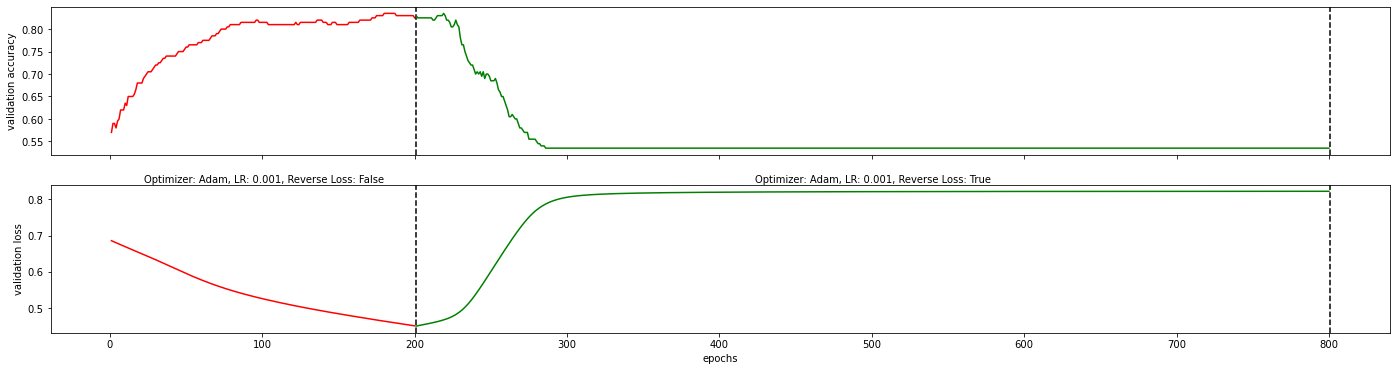

In [239]:
exam_unlearning(
    optimizers = [(Adam, 0.001), (Adam, 0.001)],
    negative_loss = [False, True],
    epochs  = [200, 600],
    )

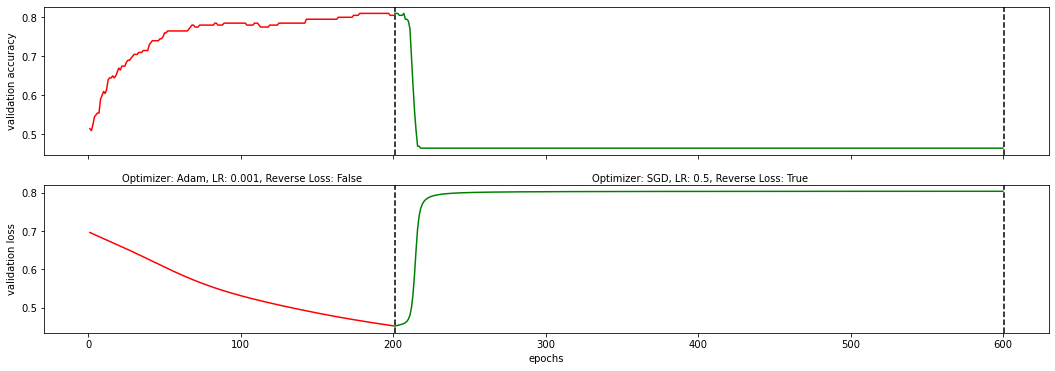

In [240]:
exam_unlearning(
    optimizers = [(Adam, 0.001), (SGD,  0.5)],
    negative_loss = [False, True],
    epochs  = [200, 400],
    )

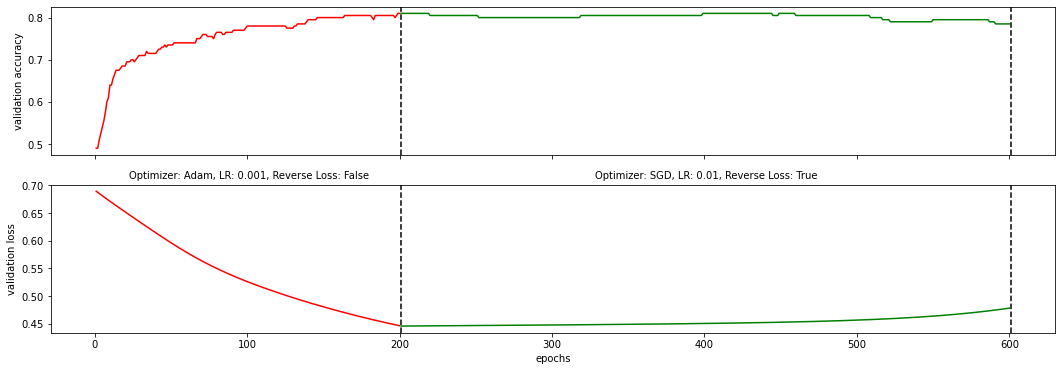

In [241]:
exam_unlearning(
    optimizers = [(Adam, 0.001), (SGD,  0.01)],
    negative_loss = [False, True],
    epochs  = [200, 400],
    )